# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [67]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from math import log, sqrt
from itertools import product
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [68]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [69]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = {arm.arm_id: arm for arm in good_arms+bad_arms}
arm_ids = list(arms.keys())

In [70]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 5.740323549556151


In [71]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [72]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        expected_payouts = {}
        for arm in arms.values():
            expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for _ in range(n)]) / n

In [73]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [74]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 575.8200000000002
random: 282.42


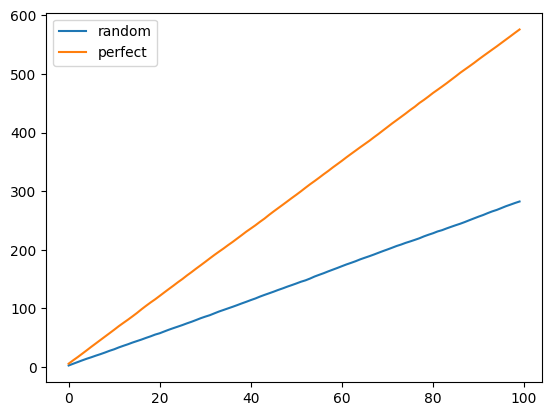

In [75]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 5.7
random: 2.56


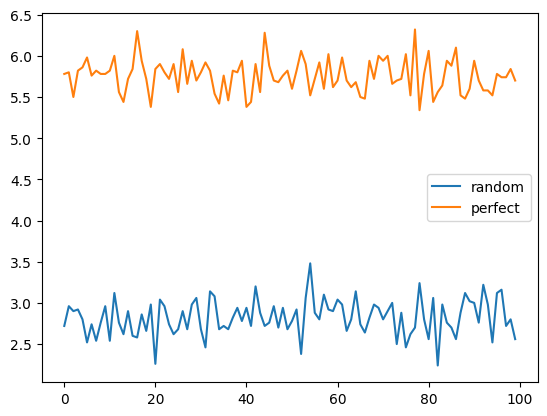

In [76]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [77]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        best_recommendations = sorted(self.payouts_per_recommendation, reverse=True)[:size]
        random_recommendations = sample(self.arm_ids, size)
        recommendations = []
        for i in range(size):
            if random() > self.epsilon:
                recommendations.append(best_recommendations[i])
                self.recommended_rates[best_recommendations[i]] += 1
            else:
                recommendations.append(random_recommendations[i])
                self.recommended_rates[random_recommendations[i]] += 1
        return recommendations

        
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

In [78]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        # te zera w mianowniku moga byc problematyczne
        # - zastanow sie, czy lepiej je obslugiwac w locie czy zainicjalizowac te mape wartosciami niezerowymi
        self.recommended_rates = {arm_id: 0.0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 0
    
    def recommend(self, size):
        boosted_payoutes_per_rec = {}
        for arm in self.payouts_per_recommendation:
            boosted_payoutes_per_rec[arm] = self.payouts_per_recommendation[arm] + self._optimism(arm)
        best_recommendations = sorted(boosted_payoutes_per_rec, reverse=True)[:size]
        for arm in best_recommendations:
            self.recommended_rates[arm] += 1
        self.n = sum(self.recommended_rates.values())
        return best_recommendations
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

    def _optimism(self, arm):
        if self.recommended_rates[arm] == 0:
            return 1.0
        return self.optimism_weight * sqrt(log(self.n) / self.recommended_rates[arm])

In [79]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        betas = {arm_id : betavariate(self.a[arm_id], self.b[arm_id]) for arm_id in self.arm_ids}
        best_recommendations = sorted(betas, reverse=True)[:size]
        return best_recommendations
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1-payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Część 3. - zgrubne porównanie bandytów

In [80]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [81]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05


/tmp/ipykernel_43359/2521350506.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_recommendations = sample(self.recommended_rates.keys(), size)


Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

ts_50_5: 6.0
ucb_10: 5.92
ts_1_50: 5.92
ts_20_20: 5.92
ts_5_10: 5.9
ts_10_10: 5.84
ts_1_1: 5.82
ts_1_10: 5.82
ts_5_5: 5.8
ts_20_5: 5.8
ts_50_1: 5.8
ucb_1: 5.74
ts_1_20: 5.74
ts_50_50: 5.72
ts_5_20: 5.7
ucb_0.1: 5.68
ts_20_10: 5.68
ucb_0.01: 5.66
ts_1_5: 5.66
ts_5_1: 5.66
ts_10_20: 5.66
ts_10_1: 5.64
ts_20_50: 5.62
ts_10_50: 5.6
perfect: 5.58
ts_50_10: 5.52
ts_20_1: 5.5
ts_5_50: 5.44
ts_50_20: 5.4
ts_10_5: 5.22
egreedy_0.25: 3.46
egreedy_0.1: 3.34
egreedy_0.05: 3.14
egreedy_0.01: 2.76
random: 2.58


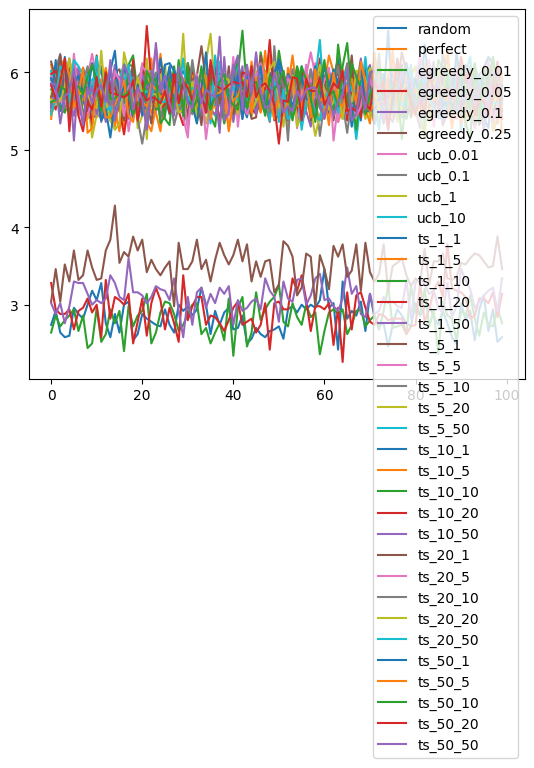

In [82]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

ts_50_1: 577.8199999999999
ts_1_20: 577.5600000000001
ts_1_10: 577.1399999999999
ts_10_1: 577.0000000000002
ucb_0.1: 576.7400000000004
ts_10_20: 576.5999999999997
ts_5_10: 576.5200000000002
ts_5_50: 575.9400000000002
ts_5_5: 575.5199999999999
ts_20_10: 575.0600000000002
ucb_0.01: 574.8599999999997
ts_20_1: 574.7399999999999
ts_50_10: 574.5999999999999
ts_10_10: 573.9600000000002
ts_5_1: 573.9400000000002
ts_50_50: 573.7600000000001
ucb_10: 573.6999999999998
ts_1_1: 573.48
ts_10_50: 572.9200000000001
ts_20_50: 572.8
perfect: 572.4200000000002
ts_50_20: 572.4200000000001
ts_20_5: 572.3799999999999
ts_1_5: 572.3199999999999
ts_20_20: 571.8
ts_5_20: 571.0199999999999
ucb_1: 570.58
ts_50_5: 570.58
ts_1_50: 569.82
ts_10_5: 569.6400000000002
egreedy_0.25: 351.54
egreedy_0.1: 310.15999999999985
egreedy_0.05: 293.71999999999997
random: 283.2800000000001
egreedy_0.01: 281.56000000000006


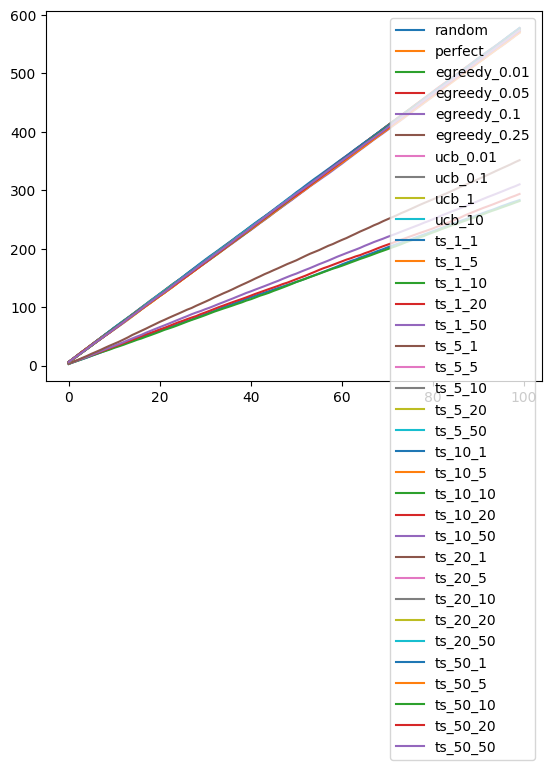

In [83]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [84]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm], k: int) -> int:
    score = 0
    for rec in recommendation[:k]:
        if rec.arm_id.startswith('good'):
            score += 1
    return score

all_relevant = relevant(list(arms.values()), len(arms))

In [85]:
# obliczmy precision@k i recall@k (zgodnie ze wzorami z wykladu)
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    return relevant(recommendation, k) / k

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    return relevant(recommendation, k) / all_relevant

In [86]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 1.0
Recall@3 for bandit ts_50_50: 0.3


In [88]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
tesing_bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms),
    EGreedy('egreedy', arm_ids, 0.05),
    UCB('ucb', arm_ids, 0.01),
    ThompsonSampling('ts_10_10', arm_ids, 10, 10)
]
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10

# dla kazdego bandyty - genetujemy `samples` rekomendacji, liczymy precision i recall, wypisujemy srednie wartosci
# powtarzamy dla kazdego k
for bandit in tesing_bandits:
    print(f'Bandit: {bandit.bandit_id}')
    for k in k_vals:
        precisions = []
        recalls = []
        for _ in range(samples):
            recommendation_ids = bandit.recommend(recommendation_size)
            recommendation = [arms[arm_id] for arm_id in recommendation_ids]
            precisions.append(precision_at_k(recommendation, k))
            recalls.append(recall_at_k(recommendation, k, all_relevant))
        print(f'Precision@{k}: {sum(precisions)/samples}')
        print(f'Recall@{k}: {sum(recalls)/samples}', end='\n\n')

Bandit: random
Precision@3: 0.16666666666666666
Recall@3: 0.05

Precision@5: 0.12
Recall@5: 0.06

Precision@10: 0.10999999999999999
Recall@10: 0.10999999999999999

Bandit: perfect
Precision@3: 1.0
Recall@3: 0.29999999999999993

Precision@5: 1.0
Recall@5: 0.5

Precision@10: 1.0
Recall@10: 1.0

Bandit: egreedy
Precision@3: 0.06666666666666667
Recall@3: 0.02

Precision@5: 0.12
Recall@5: 0.06

Precision@10: 0.16
Recall@10: 0.16

Bandit: ucb
Precision@3: 1.0
Recall@3: 0.29999999999999993

Precision@5: 1.0
Recall@5: 0.5

Precision@10: 1.0
Recall@10: 1.0

Bandit: ts_10_10
Precision@3: 1.0
Recall@3: 0.29999999999999993

Precision@5: 1.0
Recall@5: 0.5

Precision@10: 1.0
Recall@10: 1.0



/tmp/ipykernel_43359/2521350506.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_recommendations = sample(self.recommended_rates.keys(), size)
